In [1]:
from bstpp.main import LGCP_Model, Hawkes_Model, load_Chicago_Shootings, load_Boko_Haram
import numpyro.distributions as dist
import numpy as np

# Chicago Shootings Dataset
Reported shootings from the city of Chicago for the years 2022 and 2023. Data provided includes:
- latitude, longitude, and time of shooting
- demographic covariates defined on the 74 community areas of Chicago
- Polygon definition of the city of Chicago

In [2]:
#load Chicago Shooting data
data = load_Chicago_Shootings()

## Cox Hawkes Model

In [3]:
column_names = ['UNEMP_DENS','MEDINC','MED_HV','assoc_plus','VACANT_DEN',
       'VAC_HU_pct','HCUND20K_L','POP_DENS','CT_SP_WCHI']
model = Hawkes_Model(data['events_2022'],#spatiotemporal points
                     data['boundaries'],#Chicago boundaries
                     365,#Time frame (1 yr)
                     True,#use Cox as background
                     spatial_cov=data['covariates'],#spatial covariate matrix
                     cov_names = column_names,#columns to use from covariates
                     a_0=dist.Normal(1,10), alpha = dist.Beta(20,60),#set priors
                     beta=dist.HalfNormal(2.0),sigmax_2=dist.HalfNormal(0.25)
                    )

/home/imanring/PointProcess/Cox_Hawkes_Cov/bstpp/main.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  args['A_area'] = A.area.sum()/((A_[0,1]-A_[0,0])*(A_[1,1]-A_[1,0]))
/home/imanring/PointProcess/Cox_Hawkes_Cov/bstpp/main.py:213: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  intersect['area'] = intersect.area/((A_[0,1]-A_[0,0])*(A_[1,1]-A_[1,0]))


100%|████████████████| 15000/15000 [16:42<00:00, 14.96it/s, init loss: -8490.0225, avg. loss [14251-15000]: -18347.8516]



SVI elapsed time: 1024.3406121730804


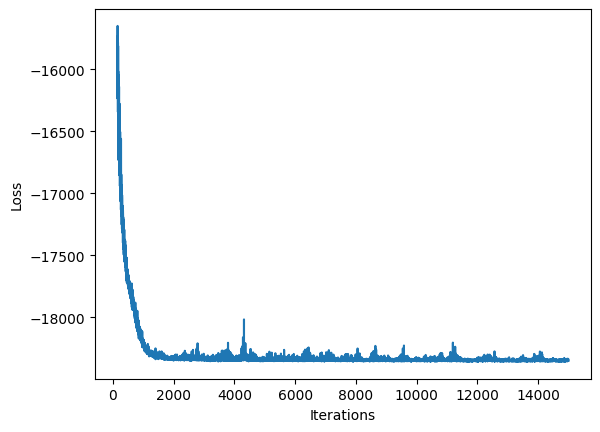

In [4]:
model.run_svi(lr=0.02,num_steps=15000)

In [5]:
model.save_rslts('output/Chicago_Shootings/cox_hawkes/output.pkl')

In [4]:
model.load_rslts('output/Chicago_Shootings/cox_hawkes/output.pkl')

In [5]:
model.log_expected_likelihood(data['events_2023'])

7509.26025390625

In [6]:
model.expected_AIC()

-18406.12109375

0.3720119297504425

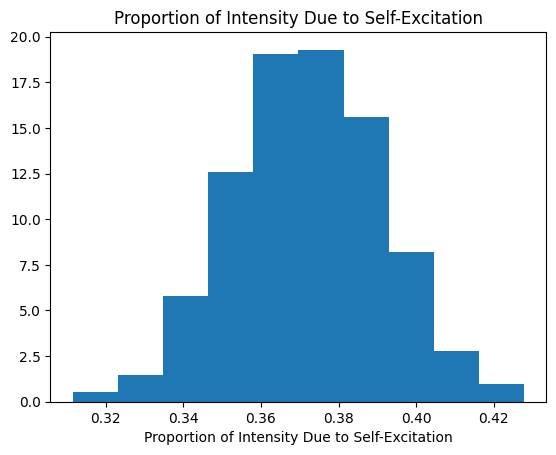

In [6]:
model.plot_prop_excitation()

,Post Mean,Post Std,P(w>0),[0.025,0.975]
alpha,0.519663,0.027255,1.0,0.467356,0.575680
beta,15.322455,0.869912,1.0,13.696313,17.139059
sigmax_2,0.000014,0.000002,1.0,0.000011,0.000017


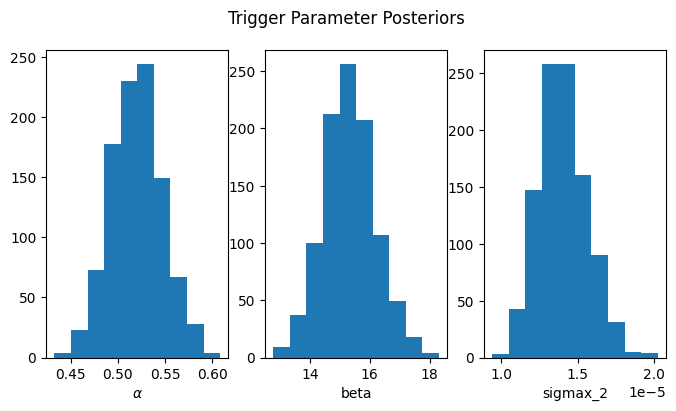

In [5]:
model.plot_trigger_posterior(trace=False)

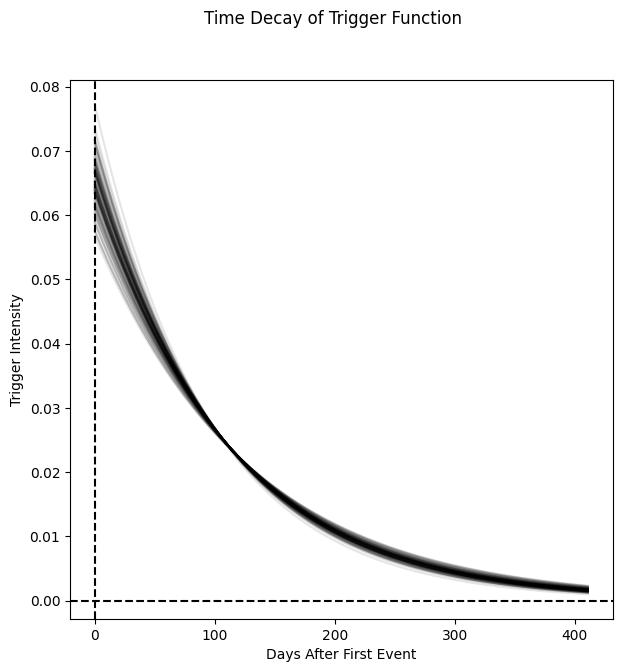

In [6]:
model.plot_trigger_time_decay()

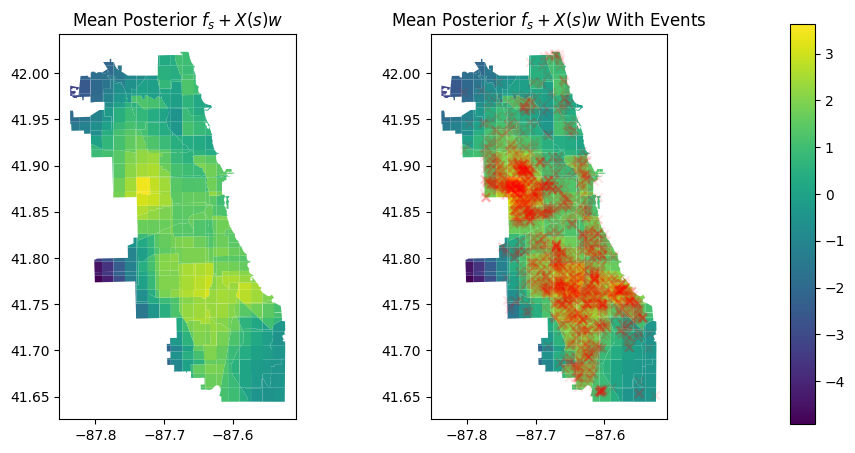

In [5]:
model.plot_spatial(include_cov=True)

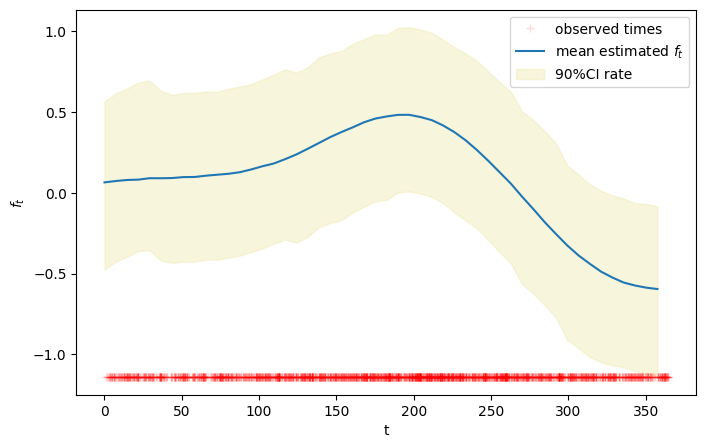

In [8]:
model.plot_temporal()

,Post Mean,Post Std,P(w>0),[0.025,0.975]
UNEMP_DENS,0.306386,0.062248,1.000,0.189508,0.432044
MEDINC,0.006433,0.081728,0.527,-0.153571,0.174928
MED_HV,-0.090982,0.098998,0.180,-0.282343,0.116833
assoc_plus,-0.132583,0.089921,0.077,-0.305087,0.041783
VACANT_DEN,0.112044,0.039022,0.998,0.037453,0.182883
VAC_HU_pct,0.091259,0.039587,0.989,0.016829,0.165188
HCUND20K_L,0.094737,0.026913,0.999,0.040015,0.144901
POP_DENS,0.494057,0.051886,1.000,0.394119,0.595436
CT_SP_WCHI,-0.150708,0.045120,0.000,-0.237306,-0.063454
a_0,2.590553,0.360308,1.000,1.879139,3.297548


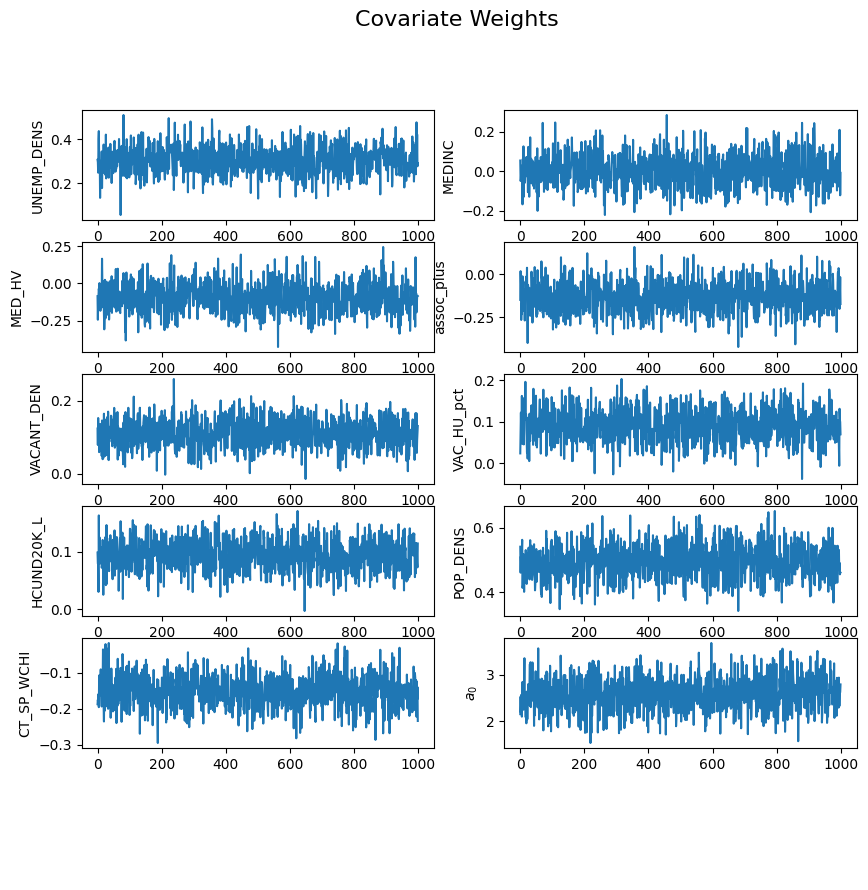

In [5]:
model.cov_weight_post_summary(trace=True)

## Trigger function Extension
Here we define a spatial trigger function for an independent spatial double exponential distribution. The trigger is assumed to be a pdf and the reproduction rate is coded separately. The required methods to implement are:
- `compute_trigger`: compute the trigger function (pdf)
- `compute_integral`: compute the integral of the trigger function given limits (cdf)
- `get_par_names`: returns a list of the parameter names used in the trigger function

`simulate_trigger` is used only if a user wishes to simulate from the trigger function.

In [5]:
from bstpp.trigger import Trigger
import jax.numpy as jnp

class spatial_double_exp(Trigger):
    def compute_trigger(self,pars,dif_mat):
         return jnp.exp(-jnp.abs(dif_mat).sum(axis=0)/pars['Lambda'])/(2*pars['Lambda'])**2
    
    def compute_integral(self,pars,limits):
        x_limits = limits[0] #shape [2,n]
        y_limits = limits[1] #shape [2,n]
        x_int = 1-0.5*jnp.exp(-jnp.abs(x_limits[0]/pars['Lambda'])) - \
            0.5*jnp.exp(-jnp.abs(x_limits[1]/pars['Lambda']))
        y_int = 1-0.5*jnp.exp(-jnp.abs(y_limits[0]/pars['Lambda'])) - \
            0.5*jnp.exp(-jnp.abs(y_limits[1]/pars['Lambda']))
        return x_int*y_int
    
    def simulate_trigger(self,pars):
        return np.random.laplace(size=2,scale=pars['Lambda'])
    
    def get_par_names(self):
        return ['Lambda']

In [14]:
model = Hawkes_Model(data['events_2022'],#spatiotemporal points
                     data['boundaries'],#Chicago boundaries
                     365,#Time frame (1 yr)
                     True,#use Cox as background
                     spatial_cov=data['covariates'],#spatial covariate matrix
                     cov_names = column_names,#columns to use from covariates
                     a_0=dist.Normal(1,10), alpha = dist.Beta(20,60),#set priors
                     beta=dist.HalfNormal(2.0),Lambda=dist.HalfNormal(0.5),
                     spatial_trig=spatial_double_exp
                    )

/home/imanring/PointProcess/Cox_Hawkes_Cov/bstpp/main.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  args['A_area'] = A.area.sum()/((A_[0,1]-A_[0,0])*(A_[1,1]-A_[1,0]))
/home/imanring/PointProcess/Cox_Hawkes_Cov/bstpp/main.py:213: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  intersect['area'] = intersect.area/((A_[0,1]-A_[0,0])*(A_[1,1]-A_[1,0]))


100%|████████████████| 15000/15000 [22:00<00:00, 11.36it/s, init loss: -8969.3467, avg. loss [14251-15000]: -19033.2070]



SVI elapsed time: 1331.333906173706


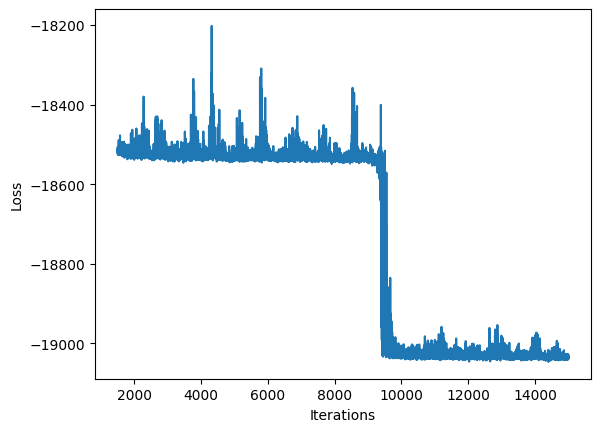

In [15]:
model.run_svi(lr=0.02,num_steps=15000)

In [16]:
model.save_rslts('output/Chicago_Shootings/cox_hawkes/output_double_exp.pkl')

In [15]:
model.load_rslts('output/Chicago_Shootings/cox_hawkes/output_double_exp.pkl')

In [16]:
model.expected_AIC()

-19106.455078125

In [17]:
model.log_expected_likelihood(data['events_2023'])

7807.57177734375

,Post Mean,Post Std,P(w>0),[0.025,0.975]
alpha,0.147088,0.008850,1.0,0.130867,0.165129
beta,18.174726,1.008495,1.0,16.244011,20.302648
Lambda,0.000098,0.000005,1.0,0.000088,0.000109


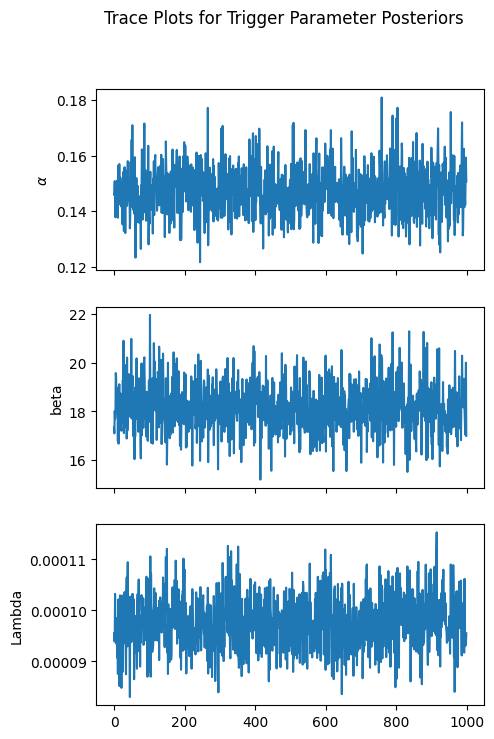

In [19]:
model.plot_trigger_posterior(trace=True)

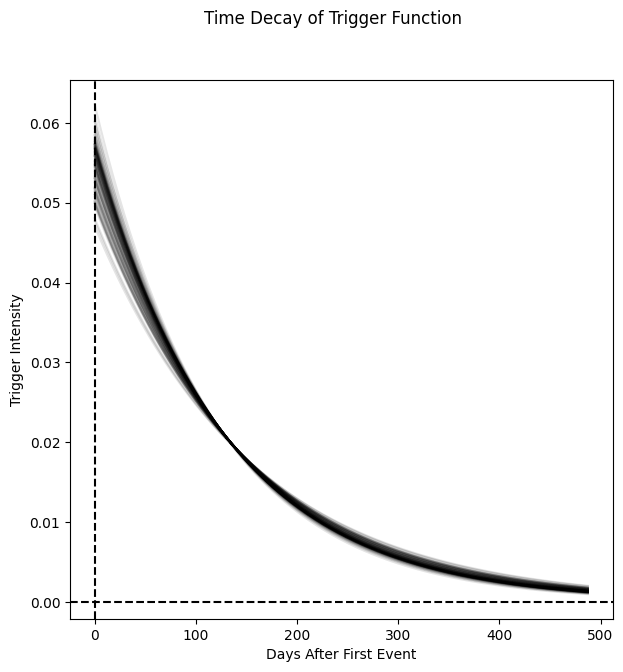

In [20]:
model.plot_trigger_time_decay()

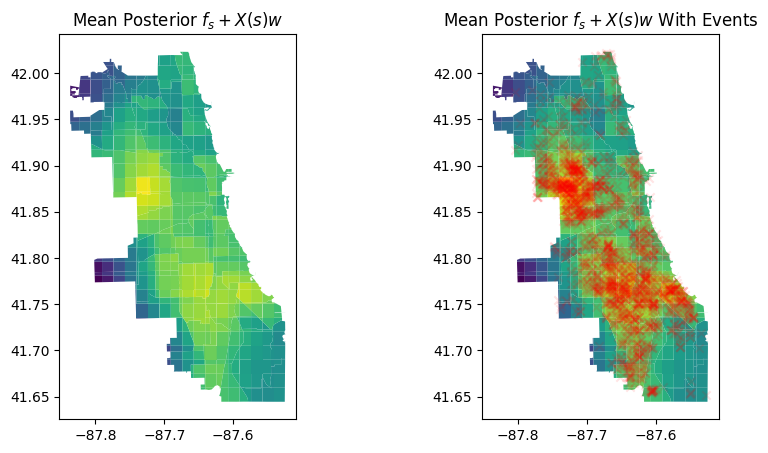

In [21]:
model.plot_spatial(include_cov=True)

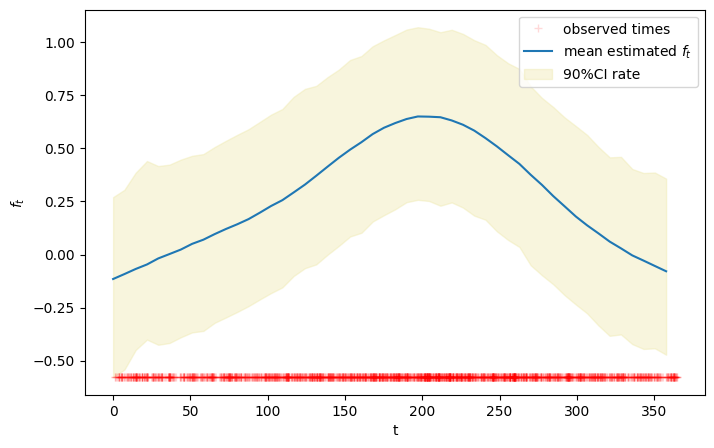

In [22]:
model.plot_temporal()

,Post Mean,Post Std,P(w>0),[0.025,0.975]
UNEMP_DENS,0.368023,0.045239,1.000,0.281966,0.457796
MEDINC,-0.011645,0.062551,0.424,-0.133912,0.119011
MED_HV,-0.162242,0.073201,0.022,-0.301816,-0.011218
assoc_plus,-0.088143,0.067171,0.096,-0.213867,0.041958
VACANT_DEN,0.099696,0.027945,1.000,0.045608,0.149519
VAC_HU_pct,0.023184,0.029211,0.772,-0.031448,0.077794
HCUND20K_L,0.105068,0.019782,1.000,0.065802,0.142814
POP_DENS,0.472448,0.038975,1.000,0.397075,0.547998
CT_SP_WCHI,-0.165509,0.031963,0.000,-0.227017,-0.104208
a_0,3.025383,0.290694,1.000,2.451419,3.595780


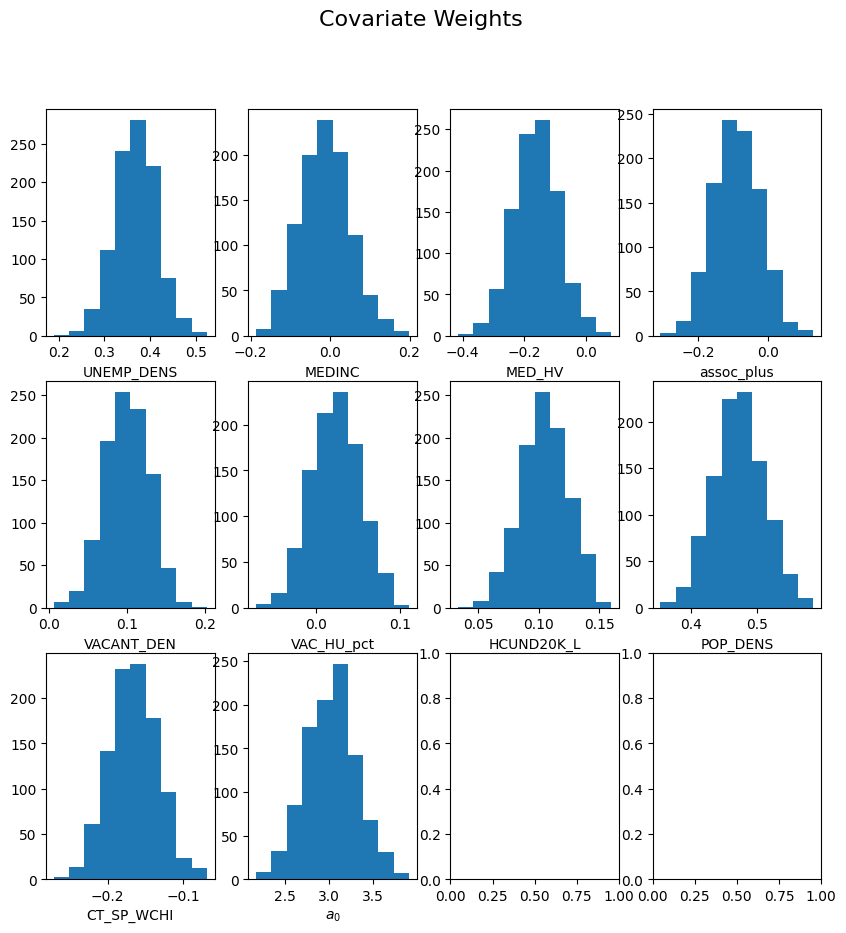

In [23]:
model.cov_weight_post_summary()

## No Covariates
See results when there are no covariates. All performance metrics decline.

In [6]:
model = Hawkes_Model(data['events_2022'],#spatiotemporal points
                     data['boundaries'],#Chicago boundaries
                     365,#Time frame (1 yr)
                     True,#use Cox as background
                     a_0=dist.Normal(1,10), alpha = dist.Beta(20,60),#set priors
                     beta=dist.HalfNormal(2.0),Lambda=dist.HalfNormal(0.5),
                     spatial_trig=spatial_double_exp
                    )

/home/imanring/PointProcess/Cox_Hawkes_Cov/bstpp/main.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  args['A_area'] = A.area.sum()/((A_[0,1]-A_[0,0])*(A_[1,1]-A_[1,0]))


100%|████████████████| 15000/15000 [22:20<00:00, 11.19it/s, init loss: -9537.4941, avg. loss [14251-15000]: -18303.0938]



SVI elapsed time: 1360.987762928009


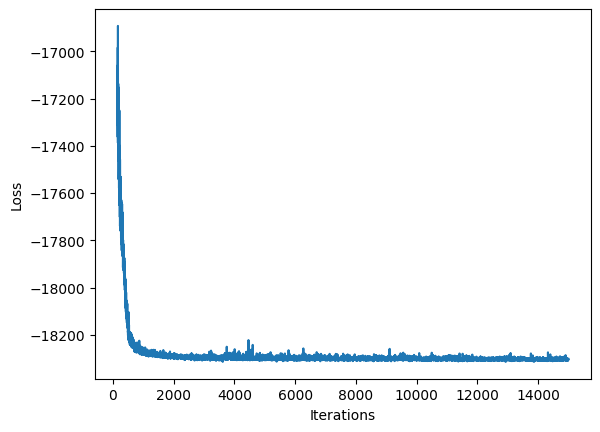

In [29]:
model.run_svi(lr=0.02,num_steps=15000)

In [30]:
model.save_rslts('output/Chicago_Shootings/cox_hawkes/output_double_exp_no_cov.pkl')

In [7]:
model.load_rslts('output/Chicago_Shootings/cox_hawkes/output_double_exp_no_cov.pkl')

In [8]:
model.expected_AIC()

-18368.54296875

In [31]:
model.log_expected_likelihood(data['events_2023'])

7476.47998046875

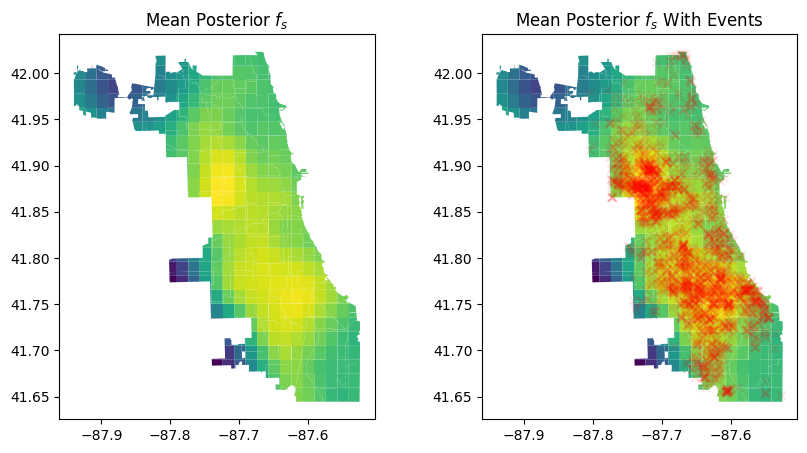

In [9]:
model.plot_spatial(include_cov=False)

## Simulation
Use the function `simulate` to simulate a new realization from the posterior mean parameters.

In [26]:
sample = model.simulate()

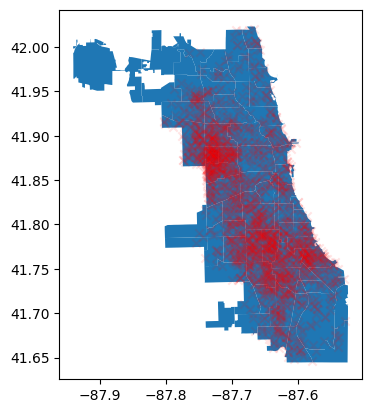

In [27]:
import matplotlib.pyplot as plt
ax = model.A.plot()
sample.plot(ax=ax,color='red',marker='x',alpha=0.1)
plt.show()

# Boko Haram Dataset
Conflict events in Nigeria involving Boko Haram. Spatial covariates from prio-grid.
### Log Gaussian Cox Process Model

In [6]:
#load Boko Haram conflicts from Nigeria
data = load_Boko_Haram()
column_names = ['droughtstart_speibase', 'urban_ih_log', 'droughtyr_speigdm',
       'herb_gc', 'capdist', 'grass_ih_log', 'nlights_sd_log', 'water_gc_log',
       'pop_gpw_sd_log', 'pasture_ih']
lgcp_bh_model = LGCP_Model(data['events'],#event data
                           data['boundaries'],#boundary of events
                           data['events']['T'].max(),
                           spatial_cov=data['covariates'],#covariate matrix
                           cov_grid_size=(0.5,0.5),#grid cell width and height to construct spatial covariate grid
                           cov_names = column_names,#columns to use from covariates
                           a_0=dist.Normal(1,10)#set prior
                          )

In [7]:
lgcp_bh_model.run_mcmc()

sample: 100%|███████████████████████████| 1500/1500 [00:36<00:00, 41.30it/s, 511 steps of size 1.25e-02. acc. prob=0.95]



                    mean       std    median      5.0%     95.0%     n_eff     r_hat
           a_0     -3.18      0.61     -3.19     -4.13     -2.16    491.08      1.00
          w[0]     -0.39      0.11     -0.39     -0.59     -0.22    658.23      1.00
          w[1]     -0.07      0.05     -0.07     -0.16     -0.00    651.68      1.00
          w[2]     -0.05      0.03     -0.05     -0.09      0.00    837.27      1.00
          w[3]      0.13      0.07      0.13      0.02      0.24    867.39      1.00
          w[4]      0.63      0.08      0.63      0.51      0.75   1055.48      1.00
          w[5]      0.18      0.04      0.18      0.12      0.23    906.50      1.00
          w[6]      0.78      0.04      0.78      0.72      0.86    927.72      1.00
          w[7]     -0.12      0.04     -0.12     -0.19     -0.05    994.49      1.00
          w[8]      0.78      0.08      0.78      0.67      0.93    661.91      1.00
          w[9]      0.58      0.05      0.58      0.50      0.67

In [8]:
lgcp_bh_model.expected_AIC()

-29747.21875

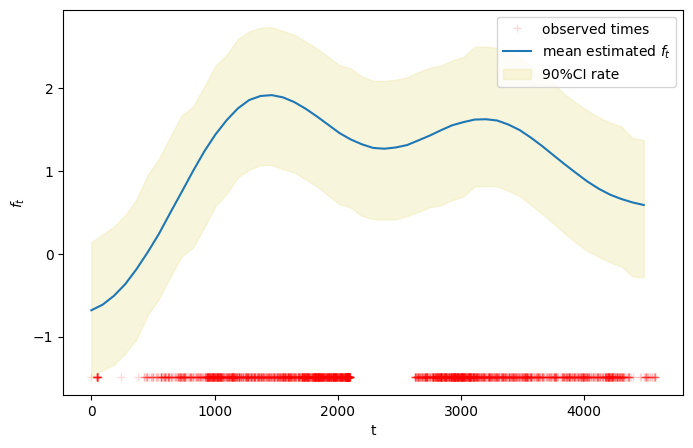

In [9]:
lgcp_bh_model.plot_temporal()

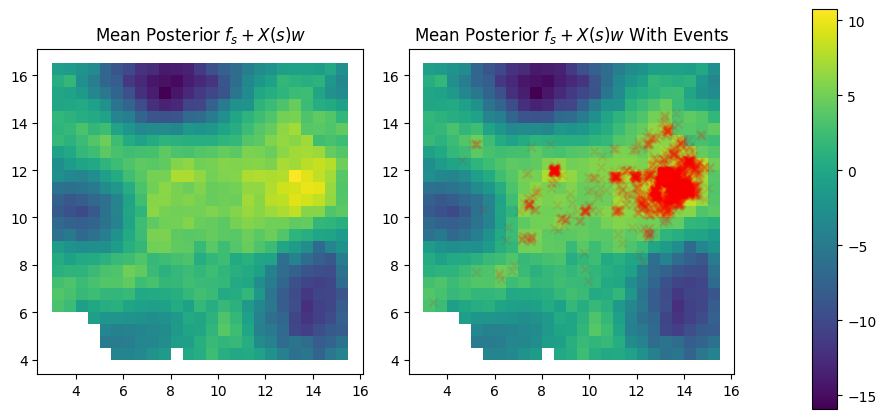

In [8]:
lgcp_bh_model.plot_spatial(include_cov=True)

,Post Mean,Post Std,z,P>|z|,[0.025,0.975]
droughtstart_speibase,-0.393704,0.113655,-3.464037,5.321333e-04,-0.616811,-0.171760
urban_ih_log,-0.068996,0.047387,-1.455993,1.453947e-01,-0.157801,0.025017
droughtyr_speigdm,-0.046708,0.028325,-1.649012,9.914511e-02,-0.098879,0.011444
herb_gc,0.128528,0.066626,1.929096,5.371897e-02,-0.001818,0.256239
capdist,0.631130,0.075291,8.382559,0.000000e+00,0.480287,0.783103
grass_ih_log,0.179572,0.036071,4.978258,6.415900e-07,0.108358,0.247056
nlights_sd_log,0.780560,0.042008,18.581089,0.000000e+00,0.700161,0.859844
water_gc_log,-0.122108,0.041723,-2.926630,3.426567e-03,-0.198359,-0.039363
pop_gpw_sd_log,0.782923,0.076487,10.236053,0.000000e+00,0.627051,0.931252
pasture_ih,0.582839,0.050643,11.508811,0.000000e+00,0.487036,0.681689


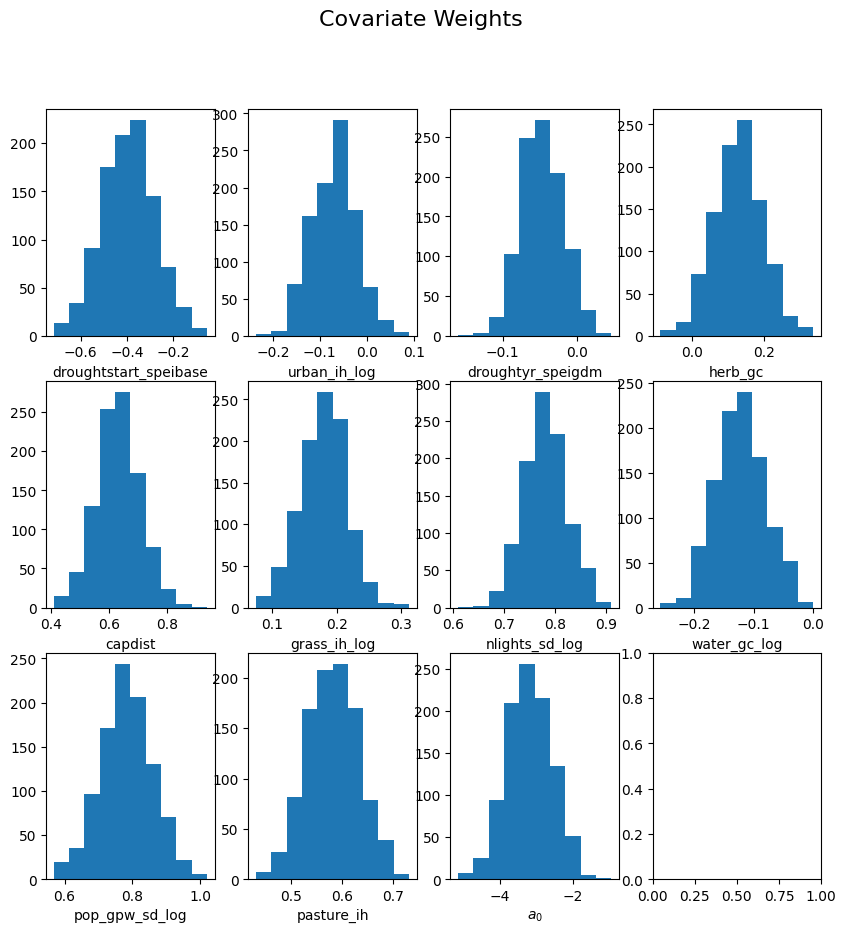

In [19]:
lgcp_bh_model.cov_weight_post_summary()

# Simulation
Simulate Cox Hawkes process with covariates and perform inference to regain original parameters. You can provide a dictionary of parameters to the `simulate` function and it will simulate a realization from those parameters.

In [30]:
from bstpp.main import Hawkes_Model
import numpyro.distributions as dist
import geopandas as gpd
from shapely.geometry import Polygon
import numpy as np
import pandas as pd

length = .1
wide = .1

cols = list(np.arange(0, 1 + wide, wide))
rows = list(np.arange(0, 1 + length, length))

polygons = []
for x in cols[:-1]:
    for y in rows[:-1]:
        polygons.append(Polygon([(x,y), (x+wide, y), (x+wide, y+length), (x, y+length)]))

In [31]:
w = np.random.normal(scale = 0.3, size = 3)
X = np.random.normal(size=(len(polygons),3))
sp_cov = gpd.GeoDataFrame(data=X,geometry=polygons)

<AxesSubplot:>

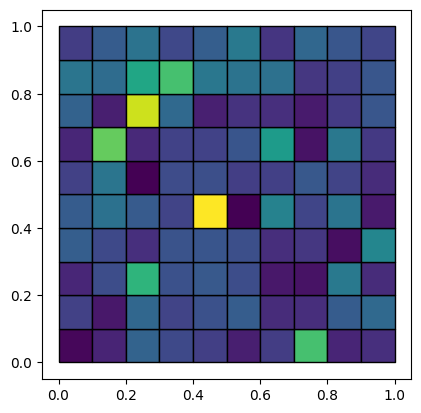

In [49]:
sp_cov['int'] = np.exp(X @ w)
sp_cov.plot('int',edgecolor='black')

In [33]:
column_names = [0,1,2]
model = Hawkes_Model(pd.DataFrame({'X':[1],'Y':[1],'T':[1]}),#spatiotemporal points
                     sp_cov,#Chicago boundaries
                     50,#Time frame (1 yr)
                     True,#use Cox as background
                     spatial_cov=sp_cov,#spatial covariate matrix
                     cov_names = column_names,#columns to use from covariates
                     a_0=dist.Normal(1,10), alpha = dist.Beta(20,60),#set priors
                     beta=dist.HalfNormal(2.0),sigmax_2=dist.HalfNormal(0.25)
                    )

In [34]:
model.args['sp_var_mu'] = 1.
par = {'alpha':0.25,'beta':2.,'a_0':.5,'sigmax_2':0.05**2,
       'z_spatial':np.random.normal(size=20),'z_temporal':np.random.normal(size=11),
       'w':w
      }
sample = model.simulate(par)

In [35]:
sample

,X,Y,T,geometry
0,0.680988,0.258745,0.587489,POINT (0.68099 0.25875)
47,0.681095,0.231631,28.137650,POINT (0.68110 0.23163)
59,0.643829,0.237727,29.514760,POINT (0.64383 0.23773)
60,0.606505,0.272597,29.804306,POINT (0.60651 0.27260)
61,0.644587,0.292776,29.561785,POINT (0.64459 0.29278)
...,...,...,...,...
721,0.164689,0.804603,40.692781,POINT (0.16469 0.80460)
686,0.788107,0.129850,48.400221,POINT (0.78811 0.12985)
735,0.794464,0.192751,49.108364,POINT (0.79446 0.19275)
747,0.385040,0.184848,46.505899,POINT (0.38504 0.18485)


<AxesSubplot:>

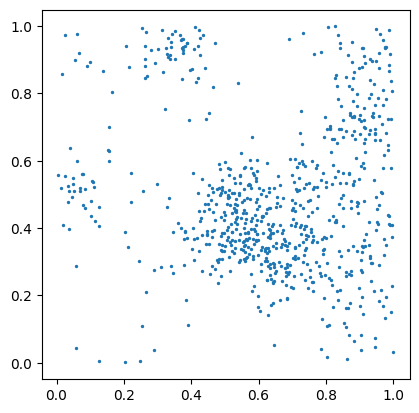

In [36]:
sample.plot(markersize=2)

In [37]:
model = Hawkes_Model(sample[['X','Y','T']].sort_values('T'),#spatiotemporal points
                     sp_cov,#Chicago boundaries
                     50,#Time frame (1 yr)
                     True,#use Cox as background
                     spatial_cov=sp_cov,#spatial covariate matrix
                     cov_names = column_names,#columns to use from covariates
                     a_0=dist.Normal(1,10), alpha = dist.Beta(20,60),#set priors
                     beta=dist.HalfNormal(2.0),sigmax_2=dist.HalfNormal(0.25)
                    )
model.args['sp_var_mu'] = 1.

100%|█████████████████| 10000/10000 [00:57<00:00, 174.56it/s, init loss: -1961.0074, avg. loss [9501-10000]: -4415.0405]



SVI elapsed time: 64.1942389011383


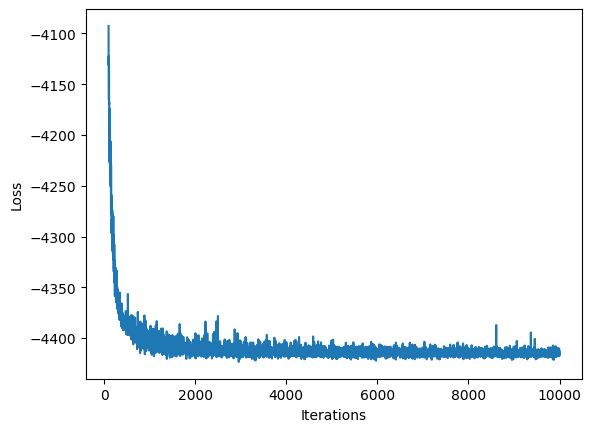

In [38]:
model.run_svi(lr=0.02,num_steps=10000)

<AxesSubplot:>

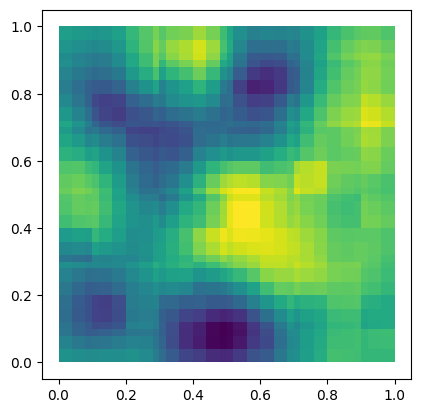

In [41]:
geo_df = model.args['int_df'].copy()
geo_df['spatial_log_intensity'] = (par['b_0'][geo_df['cov_ind'].values] + 
                       par['f_xy'][geo_df['comp_grid_id'].values])
geo_df.plot('spatial_log_intensity')

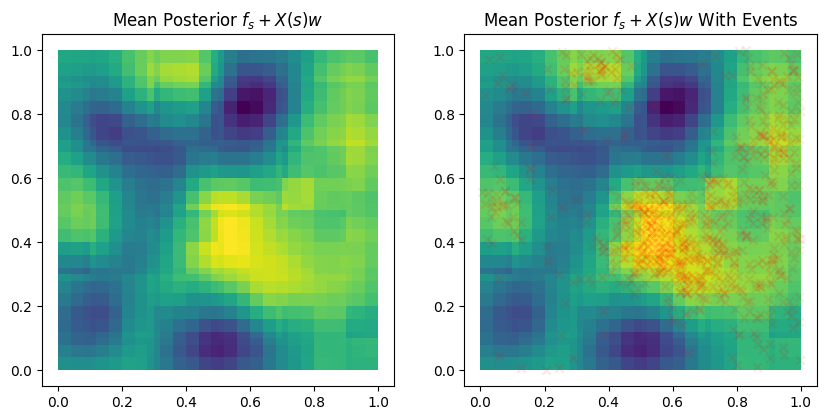

In [42]:
model.plot_spatial(include_cov=True)

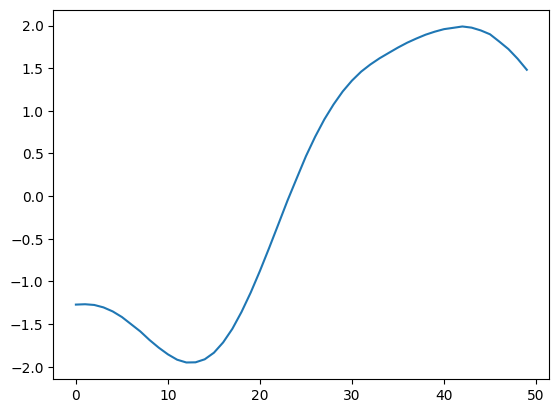

In [43]:
import matplotlib.pyplot as plt
plt.plot(par['f_t'])

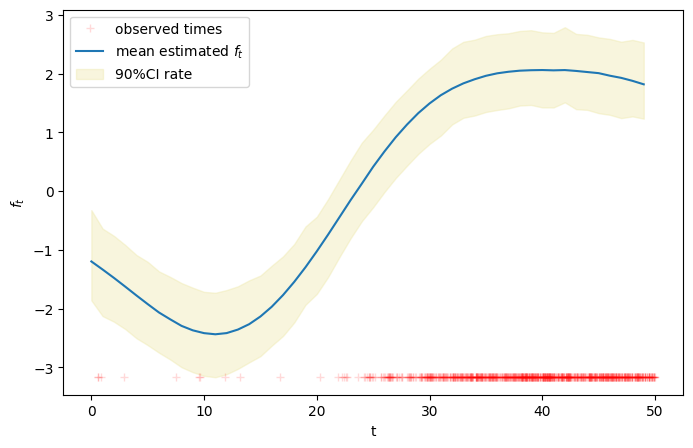

In [44]:
model.plot_temporal()

In [45]:
par['alpha'],par['beta'],par['sigmax_2']

(0.25, 2.0, 0.0025000000000000005)

,Post Mean,Post Std,z,P>|z|,[0.025,0.975]
alpha,0.258521,0.037813,6.836827,8.096634e-12,0.189993,0.336341
beta,2.152268,0.685175,3.141196,1.682591e-03,1.089722,3.744787
sigmax_2,0.003254,0.001123,2.896160,3.777600e-03,0.001589,0.005957


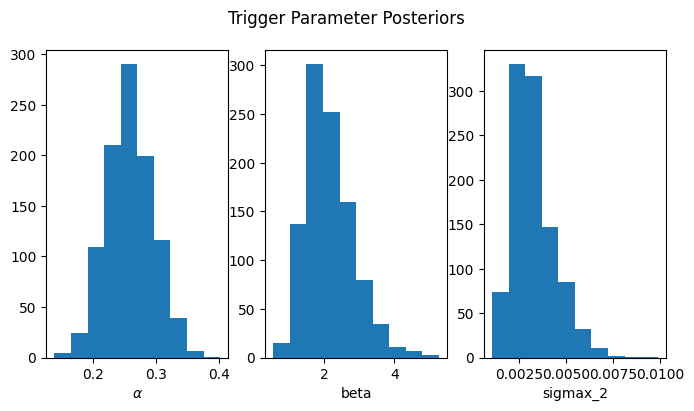

In [46]:
model.plot_trigger_posterior()

In [47]:
par['w']

array([-0.26465772,  0.0933905 ,  0.03570902])

,Post Mean,Post Std,z,P>|z|,[0.025,0.975]
0,-0.226412,0.034759,-6.513857,7.324497e-11,-0.294403,-0.158768
1,-0.012398,0.036458,-0.340073,7.338013e-01,-0.081355,0.059922
2,0.031132,0.040140,0.775585,4.379938e-01,-0.050097,0.110839
a_0,0.212017,0.419550,0.505344,6.133170e-01,-0.607814,1.034495


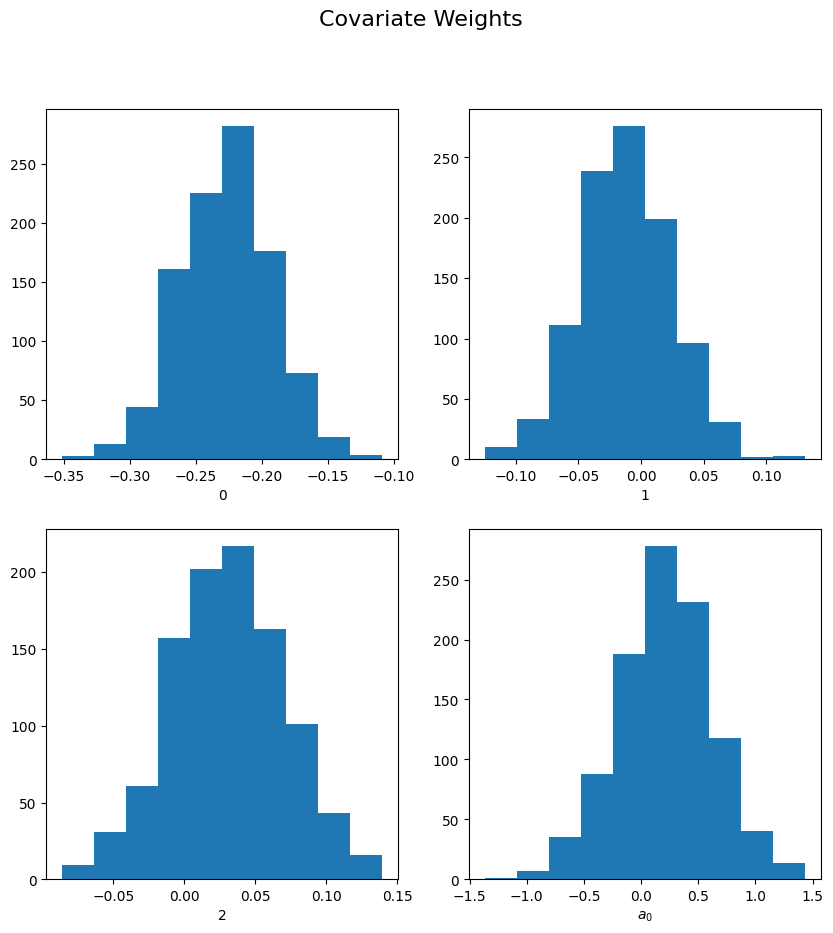

In [48]:
model.cov_weight_post_summary()